In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

In [2]:
# only to test models
# read df
df = pd.read_csv('../data/raw/Cardiovascular_Disease_Dataset/Cardiovascular_Disease_Dataset.csv')

# split data
train_df, test_df = train_test_split(df, test_size = 0.3,random_state=123)

X_train = train_df.drop(columns = ['target'])
y_train = train_df['target']
X_test = test_df.drop(columns = ['target'])
y_test = test_df['target']

# define col preprocessor
binary = ['gender','fastingbloodsugar','exerciseangia']
ohe = ['chestpain','restingrelectro']
numerical = ['age','restingBP','serumcholestrol','maxheartrate','oldpeak','noofmajorvessels']
ordinal = ['slope']
drop = ['patientid']

preprocessor = make_column_transformer(
 (StandardScaler(), numerical),
 (OneHotEncoder(), ohe),
 (OrdinalEncoder(), ordinal),
 ('passthrough', binary),
 ('drop', drop)
)
y_train

498    0
243    0
314    0
202    1
300    1
      ..
988    0
322    1
382    0
365    1
510    0
Name: target, Length: 700, dtype: int64

In [3]:
# Function adapted from DSCI 571
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [4]:
from sklearn.metrics import fbeta_score, make_scorer
models = {
    "decision tree": DecisionTreeClassifier(random_state=123),
    "Logistic Regression": LogisticRegression(random_state=123),
    "RBF SVM": SVC(random_state=123),
}

results_dict = dict()

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)

    results_dict[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, cv=5, return_train_score=True,
        scoring=make_scorer(fbeta_score, pos_label=1, beta=2))
    
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
decision tree,0.003 (+/- 0.001),0.002 (+/- 0.000),0.960 (+/- 0.024),1.000 (+/- 0.000)
Logistic Regression,0.006 (+/- 0.003),0.003 (+/- 0.001),0.957 (+/- 0.021),0.973 (+/- 0.004)
RBF SVM,0.005 (+/- 0.001),0.004 (+/- 0.002),0.970 (+/- 0.016),0.983 (+/- 0.004)


In [5]:
from sklearn.model_selection import RandomizedSearchCV


tree_param_dist = {
    'decisiontreeclassifier__max_depth': np.arange(1, 11, 2)
}
tree_model = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
search_tree = RandomizedSearchCV(tree_model, tree_param_dist, return_train_score=True, 
                                 n_jobs=-1, scoring=make_scorer(fbeta_score, pos_label=1, beta=2))
search_tree.fit(X_train, y_train)
search_tree.best_params_, search_tree.best_score_

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


({'decisiontreeclassifier__max_depth': np.int64(9)},
 np.float64(0.9619110139939451))

In [6]:
logistic_param_dist = {
    "logisticregression__C" : 10.0 ** np.arange(-3, 2, 1),
    "logisticregression__max_iter" : [80, 100, 500, 1000, 1500, 2000]
}
log_model = make_pipeline(preprocessor, LogisticRegression(random_state=123))
search_log = RandomizedSearchCV(log_model, logistic_param_dist, return_train_score=True, 
                                 n_jobs=-1, scoring=make_scorer(fbeta_score, pos_label=1, beta=2))
search_log.fit(X_train, y_train)
search_log.best_params_, search_log.best_score_

({'logisticregression__max_iter': 80,
  'logisticregression__C': np.float64(0.1)},
 np.float64(0.9608883806130925))

In [7]:
SVM_param_dist = {
    "svc__C": 10.0 ** np.arange(-3, 2, 1),
    "svc__gamma": 10.0 ** np.arange(-3, 2, 1)
}
svm_model = make_pipeline(preprocessor, SVC(random_state=123))
search_svm = RandomizedSearchCV(svm_model, SVM_param_dist, return_train_score=True, 
                                 n_jobs=-1, scoring=make_scorer(fbeta_score, pos_label=1, beta=2))
search_svm.fit(X_train, y_train)
search_svm.best_params_, search_svm.best_score_

({'svc__gamma': np.float64(0.1), 'svc__C': np.float64(1.0)},
 np.float64(0.9704429289918405))

In [8]:
#Build Final Models with Best Parameters
best_model = make_pipeline(preprocessor, SVC(C=1, gamma=0.1, random_state=123))
best_model.fit(X_train, y_train)
best_model.score(X_test, y_test)

0.97

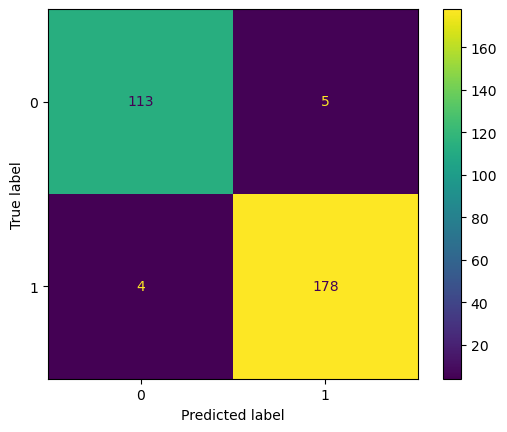

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay 

cm = ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    values_format="d",  # Show the full number 59,700 instead of 6e+04,
    # normalize='all'  # Show the proportion in each square instead of the count
)